In [2]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import random
import time



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#User input for algorithm:
#for synthetic data/potentially for regular datasets user can set the total subgroups/centroids
centroids = input("Enter number of centroids: ")
groups = input("Enter number of groups: ")

Enter number of centroids: 3
Enter number of groups: 5


In [ ]:
#calculates euclidean distance between points
def calc_dist(x,y,x_ref,y_ref):
  return np.sqrt((((x-x_ref)**2)+((y-y_ref)**2))) 


In [ ]:
#calculuates loss by inputting euclidean distance into sigmoid function
def calc_loss(x,y,x_ref,y_ref):
    # calculate Euclidean distance btw person & centroid
    distance = calc_dist(x,y,x_ref,y_ref)
    # refer to the above distance function to determine individual loss
    loss = 1/(1+ np.exp(-1*distance)) #converts distances to probability distribution
    #return loss
    return loss

In [ ]:
#function plots individual loss of all points within a cluster for all clusters in dataset
def graph_loss(clusters):
  for i in range(len(clusters)):
    plt.plot(clusters[i]['min_loss'])
    plt.title('Individual Loss for Cluster '+ str(i))
    plt.show()


In [ ]:
#this function calculates the summation of all the individual losses within each cluster for minimizing the objective function
def sum_loss(df, centroids):
  #total datapoints
  tot_len = 0
  #sum of all individual losses between clusters
  loss_sum = 0
  clusters = []
  for i in centroids.keys():
    temp = df[df['min_centr']==i]
    temp = temp.reset_index()
    clusters.append(temp)
    tot_len += len(temp)
    loss_sum += temp['min_loss'].sum()
  tot_loss = loss_sum/tot_len
  graph_loss(clusters)
  return tot_loss


In [ ]:
def assign_cluster(df, centroids):
  start = time.time()
  for i in centroids.keys():
    #loss based on euclidean distance for each individual point compared to both centroids
    #stored in dataframe
    df['loss_from_{}'.format(i)] = calc_loss(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])
    df['dist_from_{}'.format(i)] = calc_dist(df['x_coord'], df['y_coord'], centroids[i][0], centroids[i][1])

  centroid_dist_col = ['loss_from_{}'.format(i) for i in centroids.keys()]

  #df column which holds the value of the closest centroid for each point
  df['min_centr'] = df.loc[:, centroid_dist_col].idxmin(axis=1)
  df['min_centr'] = df['min_centr'].map(lambda x: int(x.lstrip('loss_from_')))
  #value of loss calculated from sigmoid in calc_loss function for individual loss
  df['min_loss'] = df[['loss_from_{}'.format(i) for i in centroids.keys()]].min(axis=1)
  end = time.time()
  print('Time elapsed Assignment Step: ', end - start)
  return df




In [ ]:
# this function compares the loss between two groups at a certain percentile level
def compare_loss(group1,group2,percentile):
    select_group = [group1, group2]
    percentile_loss = []
    for s in select_group:
        s.sort_values(by=['min_loss'])
        subgroup = [s['min_loss']] # subset the two different groups of interest
        loss_p = stats.scoreatpercentile(subgroup, percentile) # find the level of loss at given percentile
        percentile_loss.append(loss_p) # load list with loss    
    difference = percentile_loss[0]-percentile_loss[1] # find difference between two @ percentile
    return np.abs(difference)

In [ ]:
#calculates gradient for clusters
def update_weights(clust, lr, centr, df):

  x_deriv, y_deriv = 0, 0
  #total number of points in cluster 0 (points nearest to centroid 0)
  #updated centroid coordinates 
  new_centr_x, new_centr_y = centr[0], centr[1]

  #gets new assignments for clusters based on euclidean distance

  #calculate partial derivatives of euclidean distance functions

  x = clust['x_coord']
  y = clust['y_coord']
  # print('x ', x)
  # print('y ', y)
  center = clust['min_centr']
  # print('center ', center)
  distance = clust['dist_from_{}'.format(int(center))]

  numerator_x = centr[0]-x
  denominator_x = distance
  grad_x = (numerator_x/denominator_x)

  numerator_y = centr[1]-y
  denominator_y = distance
  grad_y = (numerator_y/denominator_y)

  x_deriv += grad_x
  y_deriv += grad_y
  
  loss_grad_x = x_deriv
  loss_grad_y = y_deriv
  # print('lr ', lr)

  new_centr_x -= (loss_grad_x) * lr
  new_centr_y -= (loss_grad_y) * lr
  # print(new_centr_x, new_centr_y)
  return (new_centr_x, new_centr_y)





In [ ]:
#updates centroid locations based on gradient descent and loss constraint
def update(perc, centroids,loss, df):
  b = 32
  max_iter = 150
  iter_num = 0
  groups = compute_groups(df)
  groups_len = []
  for group in groups:
    groups_len.append(len(group))
  clusters = compute_clusters(df)
  cdf1, cdf2 = compute_cdf(groups)
  #subgroup loss between max and min loss
  subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)
  #total subgroup loss to be used for evaluation with constraint
  subgroup_loss = subgroup_loss

  L = perc * subgroup_loss
  #set temporary centroids for assignment
  temp_centroids = {}
  for i in centroids.keys():
    temp_centroids[i] = centroids[i]
  
  count = {}
  for i in centroids.keys():
    count[i] = 0


  #beginning of updating 
  while subgroup_loss > L and iter_num < max_iter:
    start = time.time()
    old_loss = loss
    #set up for mini batch gradient descent
    samp = df.sample(n=b, random_state=1)
    samp = samp.reset_index()
    start = time.time()
    for s in range(len(samp)):
      clust = samp.iloc[s]['min_centr']
      clust = int(clust)
      count[clust]+=1
      lr = 1/count[clust]
      temp = update_weights(samp.iloc[s], lr, temp_centroids[clust], df)
      # temp = ((1-lr)*temp_centroids[clust][0] + lr*samp.iloc[s]['x_coord'],(1-lr)*temp_centroids[clust][1] + lr*samp.iloc[s]['y_coord'])
      temp_centroids[clust] = temp
    end = time.time()
    print('Time elapsed Batch Step: ', end - start)

    # for i in range(len(clusters)):
    #   temp = update_weights(clusters[i], lr, centroids[i], df)
    #   temp_centroids[i] = temp

    #testing to see if new centroid locations improve summation of individual loss

    df = assign_cluster(df, temp_centroids)
    groups = compute_groups(df)
    new_groups = []
    for group in groups:
      new_groups.append(len(group))
    cdf1, cdf2 = compute_cdf(groups)
    loss = sum_loss(df, temp_centroids)
    subgroup_loss = compare_loss(groups[cdf1], groups[cdf2], 50)   
    #total subgroup loss to be used for evaluation with constraint
    subgroup_loss = subgroup_loss


    if subgroup_loss > L:
      for i in centroids.keys():
        centroids[i] = temp_centroids[i]
      fig = plt.figure(figsize=(5,5))
      ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

      for i in centroids.keys():
        plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
      df = assign_cluster(df, centroids)
      plt.xlim(0, 8)
      plt.ylim(0, 8)
      ax.set_title("Synthetic Data");
      plt.show()

      iter_num += 1
    else:
      end = time.time()
      print('Time elapsed End of Update Step: ', end - start)
      return centroids
  print('Reached max iterations')    

In [ ]:
def compute_cdf(groups):
  lst = []
  for group in groups:
    sorted_data = group.sort_values(by=['min_loss'])
    sorted_len = len(sorted_data['min_loss'])
    yvals = np.arange(sorted_len)/float(sorted_len-1)
    lst.append(sorted_data['min_loss'].sum())
    plt.plot(sorted_data['min_loss'], yvals)
  plt.xlabel('loss per individual')
  plt.ylabel('% of people within certain loss of centroid')
  plt.title('Individual loss- CDF stratified by group')
  plt.show()
  max_ind = lst.index(max(lst))
  min_ind = lst.index(min(lst))
  return (max_ind, min_ind)

 

  #blue = 0 (blue points)
  #red = 1 (red points)

In [ ]:
def compute_groups(df):
  num_groups = df.group.nunique()
  groups = []
  for i in range(num_groups):
    group = df[df['group']==i]
    group = group.reset_index()
    groups.append(group)
  return groups


In [ ]:
def compute_clusters(df):
  num_clusters = df.min_centr.nunique()
  clusters = []
  for i in range(num_clusters):
    cluster = df[df['min_centr']==i]
    cluster = cluster.reset_index()
    clusters.append(cluster)
  return clusters


Time elapsed Assignment Step:  0.1443774700164795


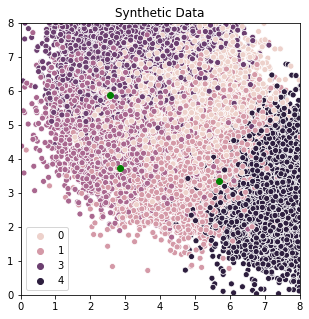

In [ ]:
from sklearn.datasets import make_blobs


# Generate Imbalanced Synthetic Data
# X,y = make_classification(n_samples=500, n_classes=3,shift=4 ,n_informative=4, n_redundant=0, n_repeated=0, n_clusters_per_class=2,class_sep=.8,flip_y=0,weights=[0.80,.1,.1], random_state=55)
center_box = (0,8)
X, y = make_blobs(n_samples=1000000, centers=int(groups), n_features=2,center_box=center_box,random_state=0)
# create dataframe to hold x and y coordinates
df = pd.DataFrame({
    'x_coord': X[:,0],
    'y_coord': X[:,1]
})

#red vs blue points
#if group = 0, then the point is in the blue group
# if group = 1, then the point is in the red group
df['group'] = y

# np.random.seed(42)

#arbitrarily picked random k (number of centroids)
k = int(centroids)
centroids = {}
#randomly initialized centroid x and y coordinates (in real data we will actually have these coordinates)
for i in range(k):
  centroids[i] = ((random.uniform(1,8)), (random.uniform(1,8)))
#colors for centroids
color_map = {}
for i in range(k):
  color_map[i] = 'g'

#plot synthetic data
fig = plt.figure(figsize=(5,5))
ax = sns.scatterplot(X[:,0],X[:,1],hue=y)

for i in centroids.keys():
  plt.scatter(centroids[i][0], centroids[i][1], color=color_map[i])
df = assign_cluster(df, centroids)
df
plt.xlim(0, 8)
plt.ylim(0, 8)
ax.set_title("Synthetic Data");
plt.show()



In [ ]:
df = assign_cluster(df, centroids)
df

Time elapsed Assignment Step:  0.16633009910583496


x_coord   y_coord  group  ...  dist_from_2  min_centr  min_loss
0      4.695978  6.746874      0  ...     3.534583          0  0.907871
1      3.306527  7.635832      3  ...     4.899163          0  0.869466
2      3.614183  5.026505      1  ...     2.663814          0  0.793718
3      4.978954  4.963950      1  ...     1.758807          2  0.853060
4      8.394400  3.689947      4  ...     2.727415          2  0.938625
...         ...       ...    ...  ...          ...        ...       ...
49995  2.491303  6.926696      3  ...     4.793670          0  0.739683
49996  5.413625  4.689818      0  ...     1.363379          2  0.796308
49997  4.942411  5.607199      0  ...     2.373004          2  0.914745
49998  5.138864  7.905574      0  ...     4.584273          0  0.963132
49999  7.756853  2.467107      4  ...     2.251306          2  0.904763

[50000 rows x 11 columns]

Time elapsed Assignment Step:  0.12864160537719727


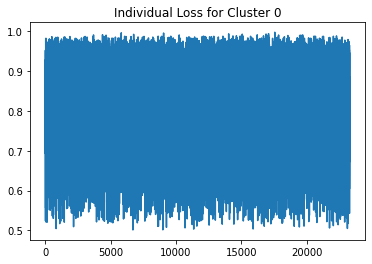

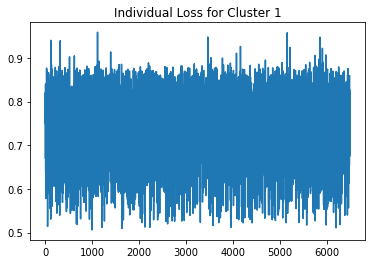

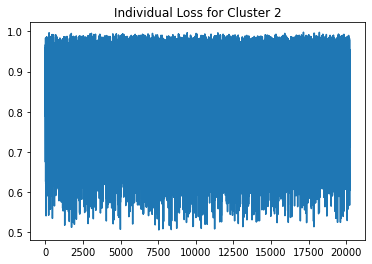

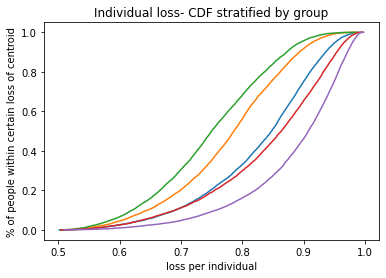

Time elapsed Batch Step:  0.012552738189697266
Time elapsed Assignment Step:  0.13244247436523438


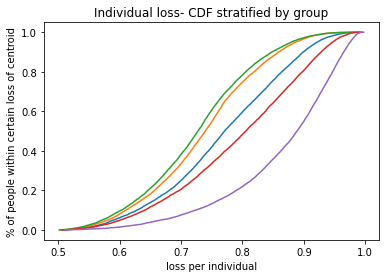

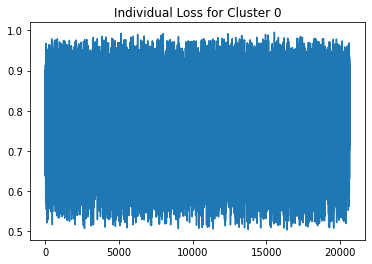

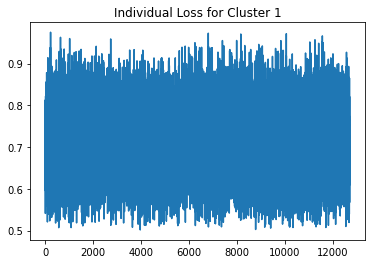

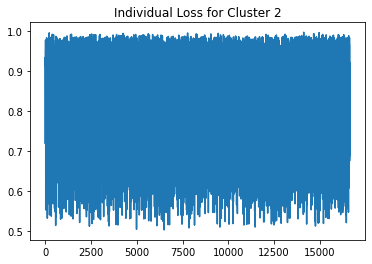

Time elapsed Assignment Step:  0.1345078945159912


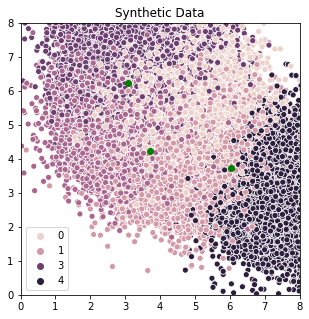

Time elapsed Batch Step:  0.012881278991699219
Time elapsed Assignment Step:  0.1468372344970703


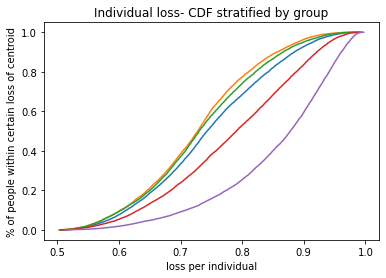

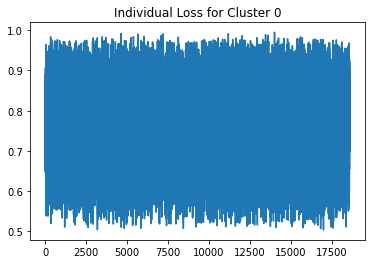

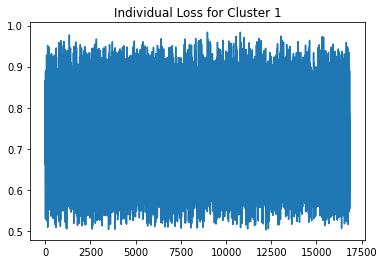

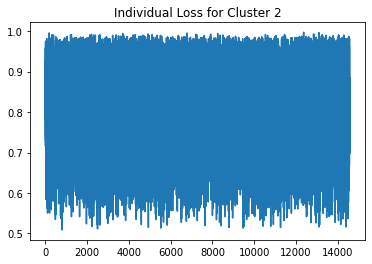

Time elapsed Assignment Step:  0.12438225746154785


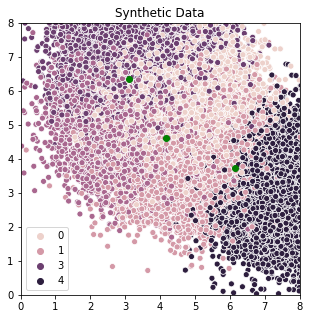

Time elapsed Batch Step:  0.012850522994995117
Time elapsed Assignment Step:  0.15332865715026855


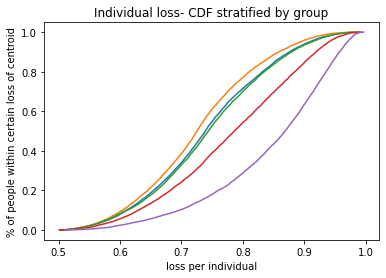

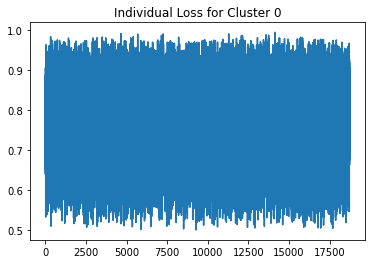

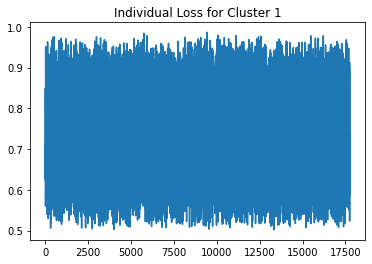

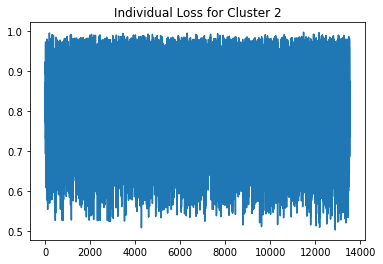

Time elapsed Assignment Step:  0.13050174713134766


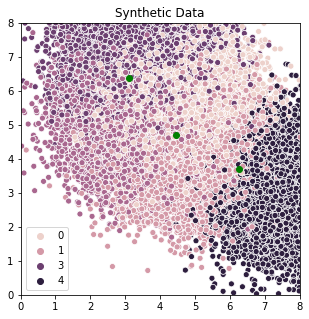

Time elapsed Batch Step:  0.012925386428833008
Time elapsed Assignment Step:  0.1376018524169922


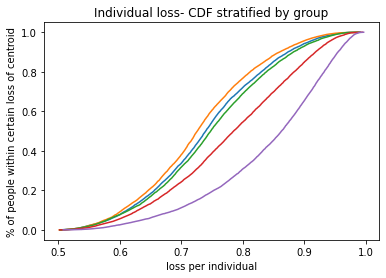

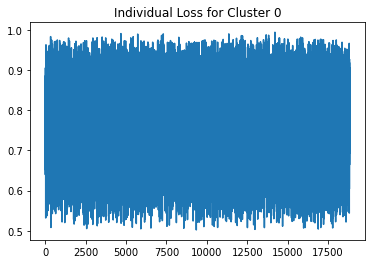

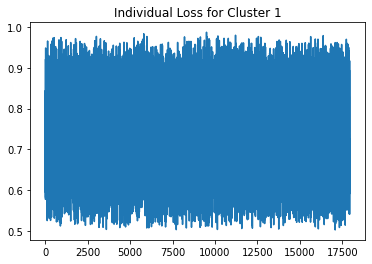

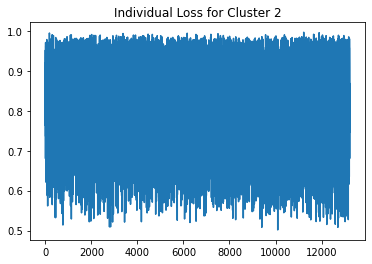

Time elapsed Assignment Step:  0.12474608421325684


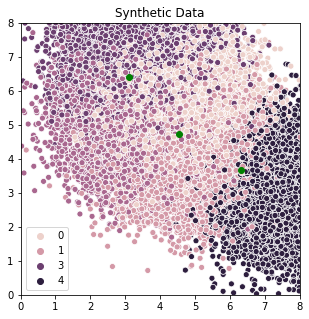

Time elapsed Batch Step:  0.02272319793701172
Time elapsed Assignment Step:  0.13749051094055176


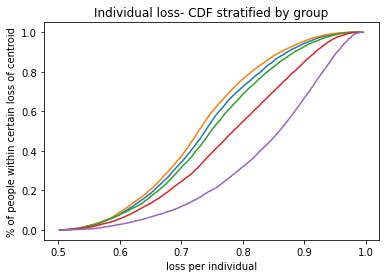

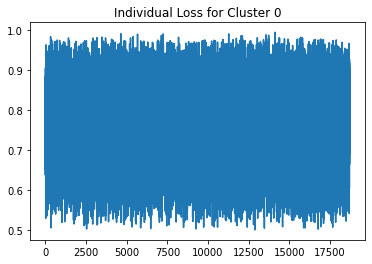

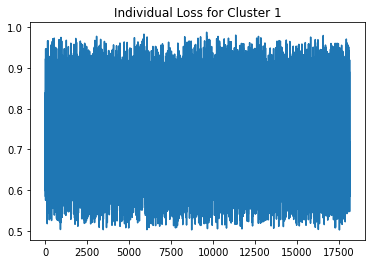

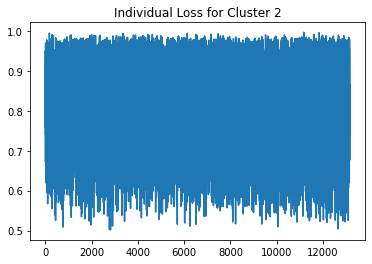

Time elapsed Assignment Step:  0.12497138977050781


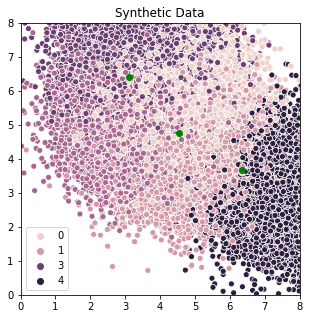

Time elapsed Batch Step:  0.012789249420166016
Time elapsed Assignment Step:  0.1551976203918457


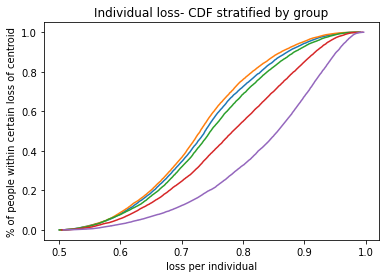

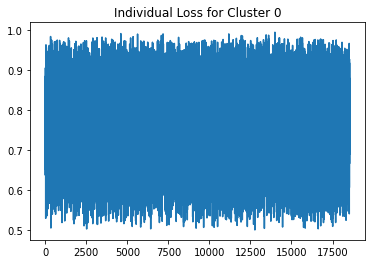

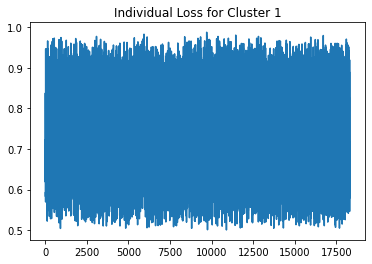

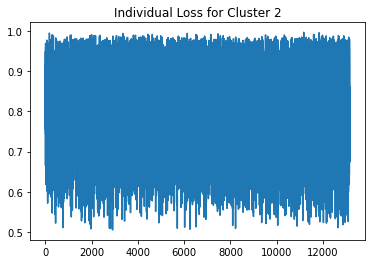

Time elapsed Assignment Step:  0.1247706413269043


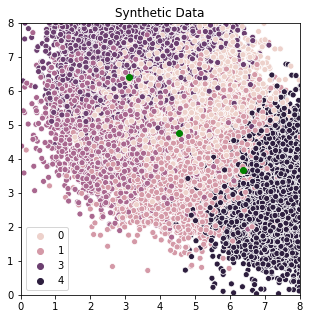

Time elapsed Batch Step:  0.019484758377075195
Time elapsed Assignment Step:  0.1437084674835205


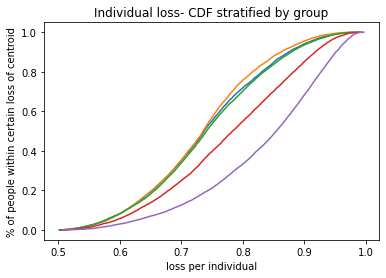

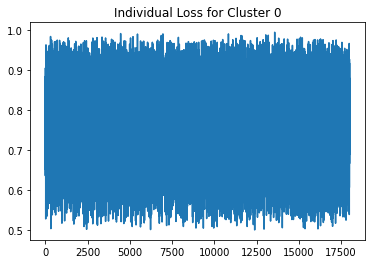

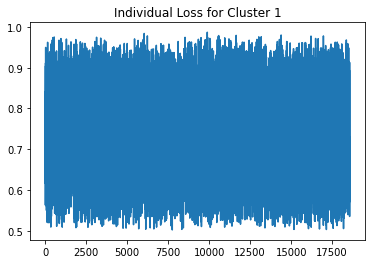

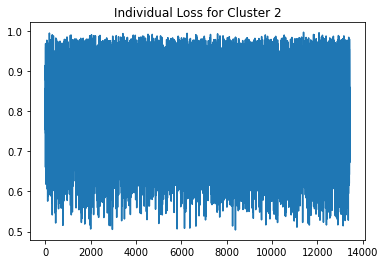

Time elapsed Assignment Step:  0.12358307838439941


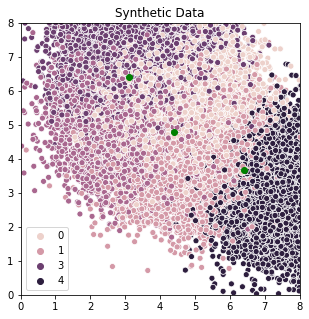

Time elapsed Batch Step:  0.012954950332641602
Time elapsed Assignment Step:  0.1655740737915039


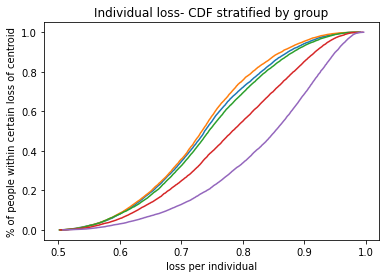

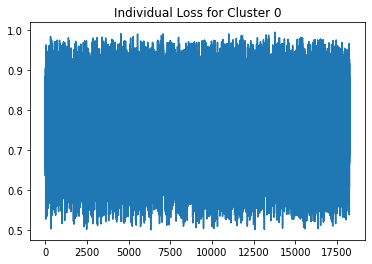

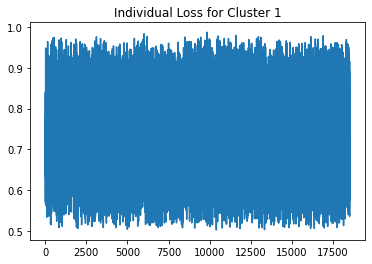

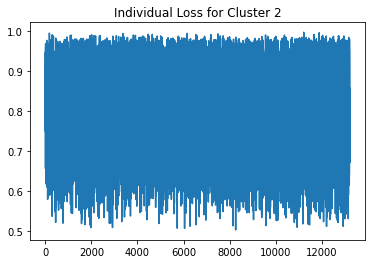

Time elapsed Assignment Step:  0.12481236457824707


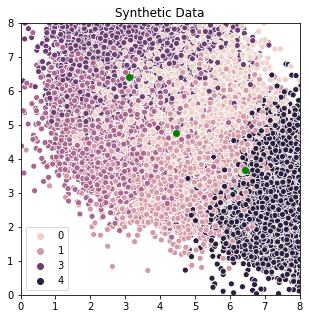

Time elapsed Batch Step:  0.02339458465576172
Time elapsed Assignment Step:  0.15188932418823242


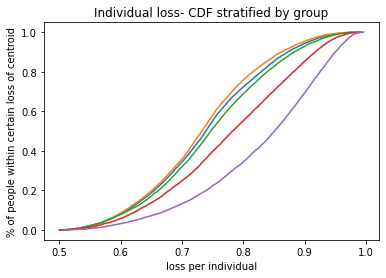

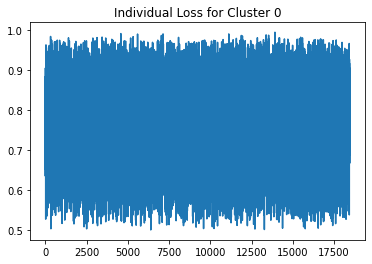

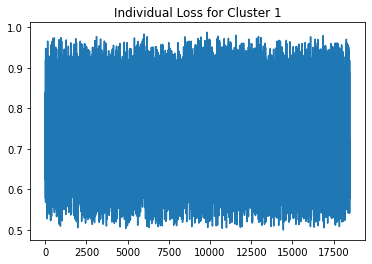

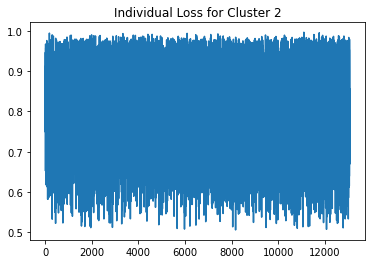

Time elapsed Assignment Step:  0.12646055221557617


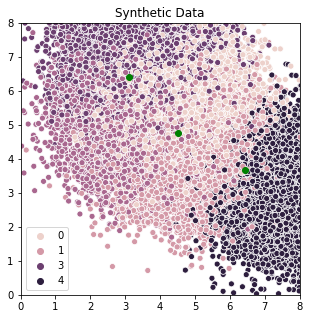

Time elapsed Batch Step:  0.012900352478027344
Time elapsed Assignment Step:  0.13950157165527344


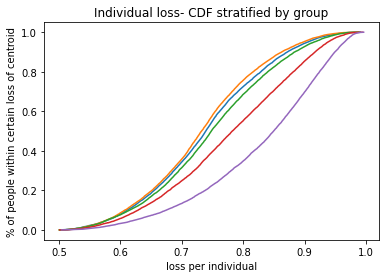

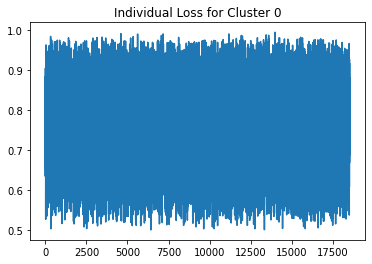

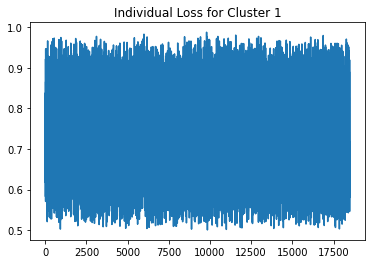

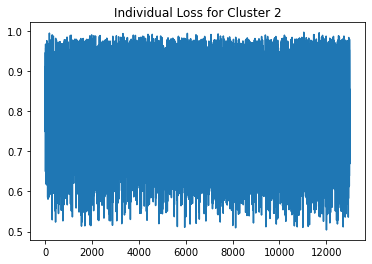

Time elapsed Assignment Step:  0.13126850128173828


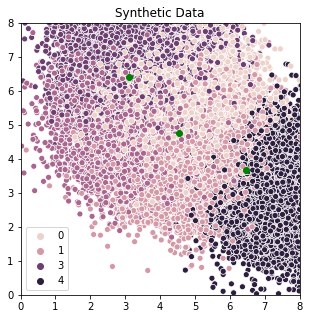

Time elapsed Batch Step:  0.021025419235229492
Time elapsed Assignment Step:  0.13084769248962402


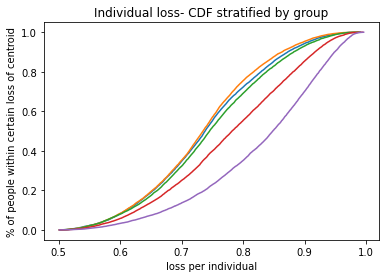

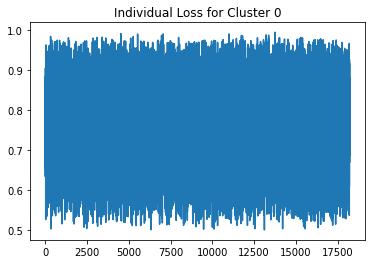

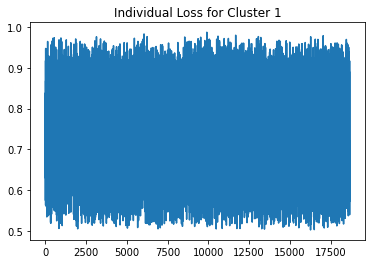

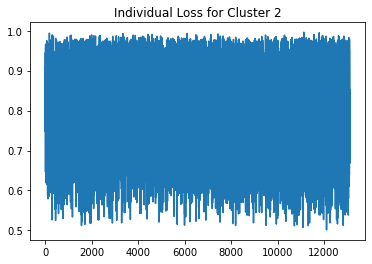

Time elapsed Assignment Step:  0.1262519359588623


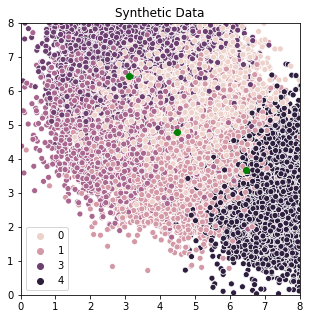

Time elapsed Batch Step:  0.021495580673217773
Time elapsed Assignment Step:  0.1425025463104248


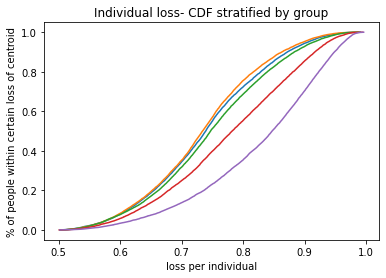

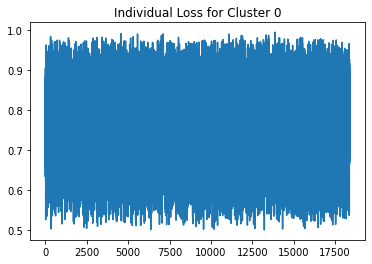

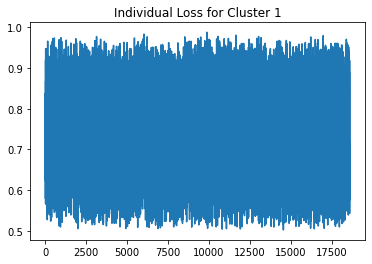

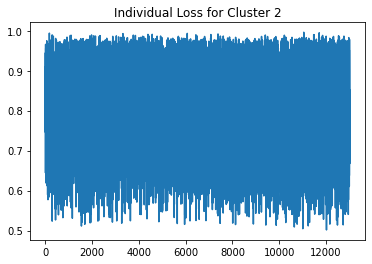

Time elapsed Assignment Step:  0.124603271484375


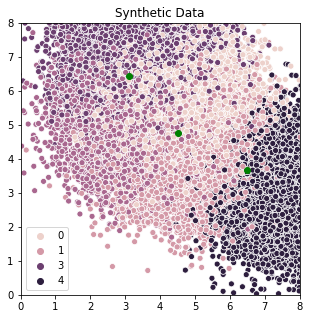

Time elapsed Batch Step:  0.012973308563232422
Time elapsed Assignment Step:  0.1417524814605713


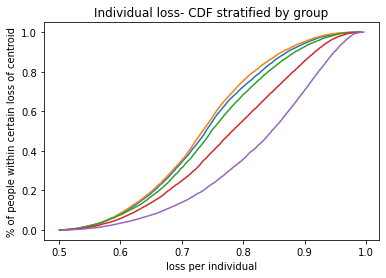

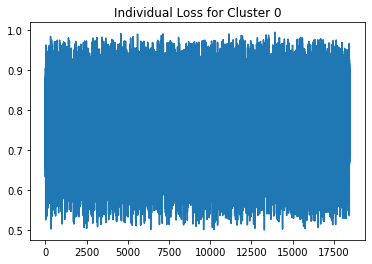

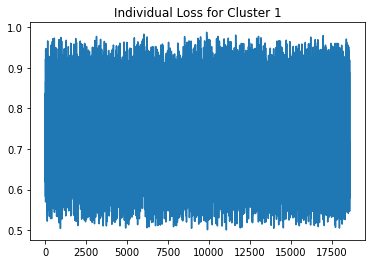

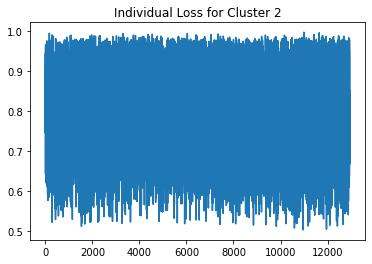

Time elapsed Assignment Step:  0.12470364570617676


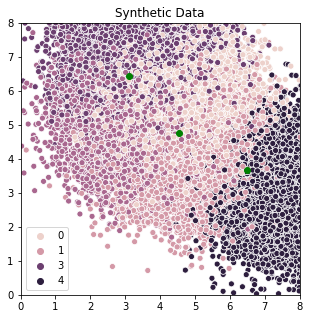

Time elapsed Batch Step:  0.012822866439819336
Time elapsed Assignment Step:  0.1377568244934082


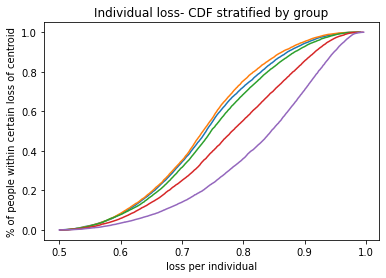

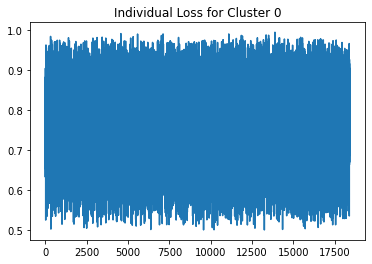

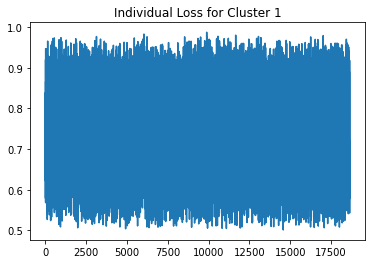

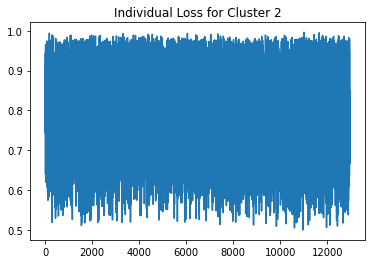

Time elapsed Assignment Step:  0.12470269203186035


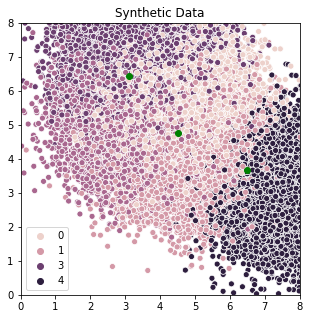

Time elapsed Batch Step:  0.018790006637573242
Time elapsed Assignment Step:  0.1580371856689453


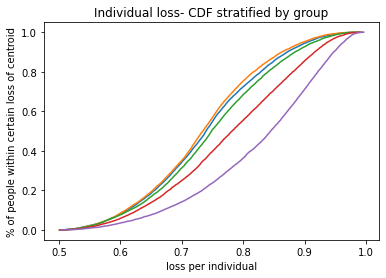

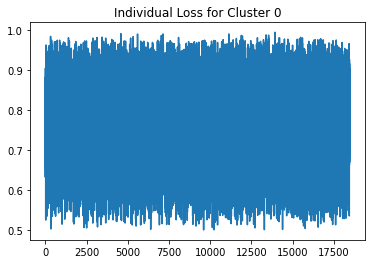

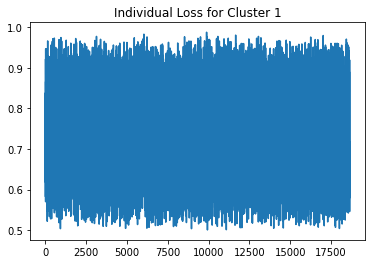

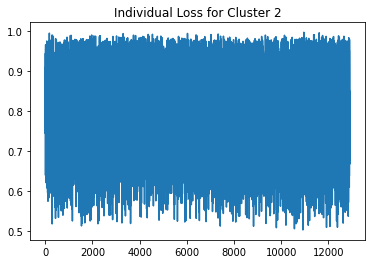

Time elapsed End of Update Step:  1.2710254192352295


{0: (3.1023961941449025, 6.432488518883348),
 1: (4.516352847135664, 4.769640648229359),
 2: (6.503455399934981, 3.658584714568712)}

In [ ]:
df = assign_cluster(df, centroids)
df
loss = sum_loss(df, centroids)
loss 
update(.7, centroids,loss,df )

In [ ]:
centroids 

{0: (3.1023961941449025, 6.432488518883348),
 1: (4.516352847135664, 4.769640648229359),
 2: (6.503455399934981, 3.658584714568712)}